In [ ]:
import pandas as pd
import numpy as np
import torch
from fastai.data.core import DataLoaders
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.core import TabularPandas, Normalize, RegressionBlock
from fastai.tabular.all import *
from fastai.torch_core import tensor
from torch import nn
from fastai.learner import Learner
from fastai.metrics import mse
from fastai.callback.schedule import *
import yfinance as yf
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
train_file_path = "/content/drive/My Drive/StockData/final_validtest_set.csv"
test_file_path = "/content/drive/My Drive/StockData/final_test_set.csv"

if os.path.exists(test_file_path):
    test_df = pd.read_csv(test_file_path)
    print("Data loaded from CSV.")
if os.path.exists(train_file_path)    :
    train_df = pd.read_csv(train_file_path)
    print("Data loaded from CSV.")

Mounted at /content/drive
Data loaded from CSV.
Data loaded from CSV.


In [ ]:
cont_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume', 'rsi','stochastic','signal-stochastic','cci', 'williams%R','roc','awesome-oscillator','ultimate-oscillator','trix','KAMA','stochrsi','sma','macd','ema','adx','psar-up','psar-down', 'ichimoku_a','ichimoku_b','supertrend','KST','plus_di','minus_di','VI-dff','VI+','VI-','atr','bb_bbm',
              'donchianwidth','keltnerwidth','ulcer','chaikin_volatility','historical_volatility','upper_band','lower_band'] # Remove 'Ticker' from cont_vars
seq_length = 20
forecast_horizon = 14
target_col = 'return_14d'
ticker_col = 'Ticker'
date_col = 'Date'
batch_size = 64  # You can adjust this
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# === Define the LSTM regression model ===
import torch
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        # x shape: (batch, seq_length, n_features)
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]  # take output from last time step
        return self.fc(last_out).squeeze(-1)

# === Load the trained learner ===
from fastai.learner import load_learner
import os # Ensure os is imported if not already

learner_path = '/content/drive/MyDrive/StockModels'
export_path = os.path.join(learner_path, 'lstm_learner.pkl')

# Load the learner after the class definition
try:
    learner = load_learner(export_path)
    print(learner)
except FileNotFoundError:
    print(f"Error: Learner file not found at {export_path}. Ensure the training cell was run successfully.")

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

seq_length = 20
forecast_horizon = 14
cont_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'rsi','stochastic','signal-stochastic','cci', 'williams%R','roc','awesome-oscillator','ultimate-oscillator','trix','KAMA','stochrsi','sma','macd','ema','adx','psar-up','psar-down', 'ichimoku_a','ichimoku_b','supertrend','KST','plus_di','minus_di','VI-dff','VI+','VI-','atr','bb_bbm',
              'donchianwidth','keltnerwidth','ulcer','chaikin_volatility','historical_volatility','upper_band','lower_band'] # Must match the features used for training
target_col = 'return_14d'
ticker_col = 'Ticker'
date_col = 'Date'
batch_size = 64

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, df, seq_length, forecast_horizon, cont_vars, target_col, ticker_col, date_col, index_map=None):
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.cont_vars = cont_vars
        self.target_col = target_col
        self.ticker_col = ticker_col
        self.date_col = date_col

        self.original_index = df.index

        df = df.sort_values([ticker_col, date_col]).reset_index(drop=True)

        self.df = df

        self.groups = list(df.groupby(ticker_col))

        if index_map is None:
            self.index_map = []
            for t_idx, (ticker, group) in enumerate(self.groups):
                n = len(group)
                max_start = n - seq_length - forecast_horizon
                if max_start >= 0:
                     for start in range(max_start + 1):
                         target_pos_in_group = start + seq_length + forecast_horizon - 1
                         if start + seq_length <= n and target_pos_in_group < n:
                              original_idx = group.iloc[target_pos_in_group].name
                              self.index_map.append((t_idx, start, original_idx))
        else:
            self.index_map = index_map


    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        t_idx, start, original_idx = self.index_map[idx]
        ticker, group = self.groups[t_idx]

        seq_start = start
        seq_end = start + self.seq_length
        target_pos_in_group = seq_end + self.forecast_horizon - 1

        features = group.iloc[seq_start:seq_end][self.cont_vars].values.astype(np.float32)


        target = group.iloc[target_pos_in_group][self.target_col].astype(np.float32)

        X = torch.tensor(features)
        y = torch.tensor(target)

        return X, y, original_idx



if 'test_df' in locals():
     test_df_for_dataset = test_df.copy()

     test_df_for_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)


     if not test_df_for_dataset.empty:
         cont_vars_test = [col for col in cont_vars if col in test_df_for_dataset.columns]
         if cont_vars_test:
             test_df_for_dataset[cont_vars_test] = test_df_for_dataset.groupby('Ticker')[cont_vars_test].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))


             for col in cont_vars_test:
                 median_val = test_df_for_dataset[col].median()
                 if pd.isna(median_val):
                     test_df_for_dataset[col].fillna(0, inplace=True)
                 else:
                     test_df_for_dataset[col].fillna(median_val, inplace=True)
         else:
             print("Warning: None of the specified continuous variables found in the test DataFrame.")



     if target_col in test_df_for_dataset.columns:
          initial_test_rows = len(test_df_for_dataset)
          test_df_for_dataset = test_df_for_dataset.dropna(subset=[target_col]).reset_index(drop=True)
          test_df_for_dataset = test_df_for_dataset[~test_df_for_dataset[target_col].isin([np.inf, -np.inf])].reset_index(drop=True)
          if len(test_df_for_dataset) < initial_test_rows:
              print(f"Dropped {initial_test_rows - len(test_df_for_dataset)} rows from test_df_for_dataset due to NaN/inf in target column.")
     else:
         print(f"Warning: Target column '{target_col}' not found in test_df_for_dataset. Skipping target cleaning.")

     test_df_for_dataset = test_df_for_dataset.sort_values(['Ticker', 'Date']).reset_index(drop=True)

     test_ds = TimeSeriesDataset(
         test_df_for_dataset, seq_length, forecast_horizon, cont_vars, target_col,
         ticker_col, date_col
     )
     test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)
     preds_list = []
     targs_list = []
     original_indices_list = []

     learner.model.eval()

     eval_device = learner.dls.device if hasattr(learner.dls, 'device') and learner.dls.device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     learner.model.to(eval_device)

     with torch.no_grad():
         for inputs, targets, indices in test_dl:

             inputs = inputs.to(eval_device)

             outputs = learner.model(inputs)

             preds_list.append(outputs.cpu().numpy())
             targs_list.append(targets.cpu().numpy())
             original_indices_list.append(indices.cpu().numpy())


     preds = np.concatenate(preds_list)
     targs = np.concatenate(targs_list)
     original_indices = np.concatenate(original_indices_list)

     print(f"Generated {len(preds)} predictions from the test set.")
     print(f"Collected {len(targs)} corresponding true values.")
     print(f"Collected {len(original_indices)} corresponding original indices.")


     finite_mask_metrics = np.isfinite(preds) & np.isfinite(targs)
     if np.sum(finite_mask_metrics) > 0:
         mae_val = mean_absolute_error(targs[finite_mask_metrics], preds[finite_mask_metrics])
         mse_val = mean_squared_error(targs[finite_mask_metrics], preds[finite_mask_metrics])
         print(f"\nTest MAE (on finite prediction/target pairs): {mae_val:.4f}")
         print(f"Test MSE (on finite prediction/target pairs): {mse_val:.4f}")
     else:
          print("\nNo finite prediction/target pairs available to compute MAE/MSE.")
          mae_val, mse_val = np.nan, np.nan


else:
    print("Error: test_df not found. Ensure previous cells creating and cleaning test data were run.")

<ipython-input-34-105bca5c1714>:113: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df_for_dataset[cont_vars_test] = test_df_for_dataset.groupby('Ticker')[cont_vars_test].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))
<ipython-input-34-105bca5c1714>:113: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df_for_dataset[cont_vars_test] = test_df_for_dataset.groupby('Ticker')[cont_vars_test].transform(lambda grp: grp.fillna(method='ffill').fillna(method='bfill'))
<ipython-input-34-105bca5c1714>:122: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

Dropped 6936 rows from test_df_for_dataset due to NaN/inf in target column.
Generated 44563 predictions from the test set.
Collected 44563 corresponding true values.
Collected 44563 corresponding original indices.

Test MAE (on finite prediction/target pairs): 0.0538
Test MSE (on finite prediction/target pairs): 0.0056


In [ ]:
if len(original_indices) > 0:
    original_indices = original_indices.astype(int)

    if 'test_df' in locals():
        if not pd.Index(original_indices).isin(test_df.index).all():
            print("Warning: Some original indices are not present in the original test_df.")
            valid_indices_mask = pd.Index(original_indices).isin(test_df.index)
            original_indices = original_indices[valid_indices_mask]
            preds = preds[valid_indices_mask]
            targs = targs[valid_indices_mask]
            print(f"Filtered down to {len(original_indices)} valid indices.")

        eval_df_source = test_df.loc[original_indices].reset_index(drop=True)

        if len(targs) == len(preds) == len(eval_df_source):
            eval_df = pd.DataFrame({
                'Date': eval_df_source['Date'].values,
                'Ticker': eval_df_source['Ticker'].values,
                'Close': eval_df_source['Close'].values,
                'y_true': targs,
                'y_pred': preds,
                'rsi': eval_df_source['rsi'].values,
                'stochastic': eval_df_source['stochastic'].values,
                'return_14d': eval_df_source['return_14d'].values
            })
        eval_df['AbsError'] = np.abs(eval_df['y_true'] - eval_df['y_pred'])

<ipython-input-38-37dd37d75f6d>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  risk_metrics_df = eval_df.groupby('Ticker').apply(



--- Group 1 - Worst Predictions ---
   Ticker  AvgPrice  TrueMean  PredMean  AvgAbsError    Sharpe
71    NKE  0.141332  0.161117  0.010150     0.157525  0.120197
58   LULU  0.424269 -0.063298  0.034684     0.133629  0.161378
81    SJM  0.288274  0.124682  0.020747     0.117537  0.039715
65   MKTX  0.142074  0.006033 -0.012430     0.115292 -0.224155
29      D  0.331864 -0.060095  0.035318     0.112083  0.029765
76   POOL  0.450806 -0.051637  0.034248     0.093400  0.147580
18    CAG  0.343275  0.089539  0.005453     0.091759 -0.266446
11   BALL  0.361104 -0.049730  0.037166     0.087688 -0.382379
87    TGT  0.327621  0.044581 -0.008668     0.081351  0.059662
85   TECH  0.359791  0.057561  0.002198     0.079725  0.031577

--- Group 2 - Worst Predictions ---
    Ticker  AvgPrice  TrueMean  PredMean  AvgAbsError    Sharpe
168    RMD  0.611007  0.067754  0.008707     0.124146  0.509485
113   CTSH  0.659718 -0.047118  0.034728     0.101680  0.413352
116    DOW  0.554789 -0.070599  0.003229 

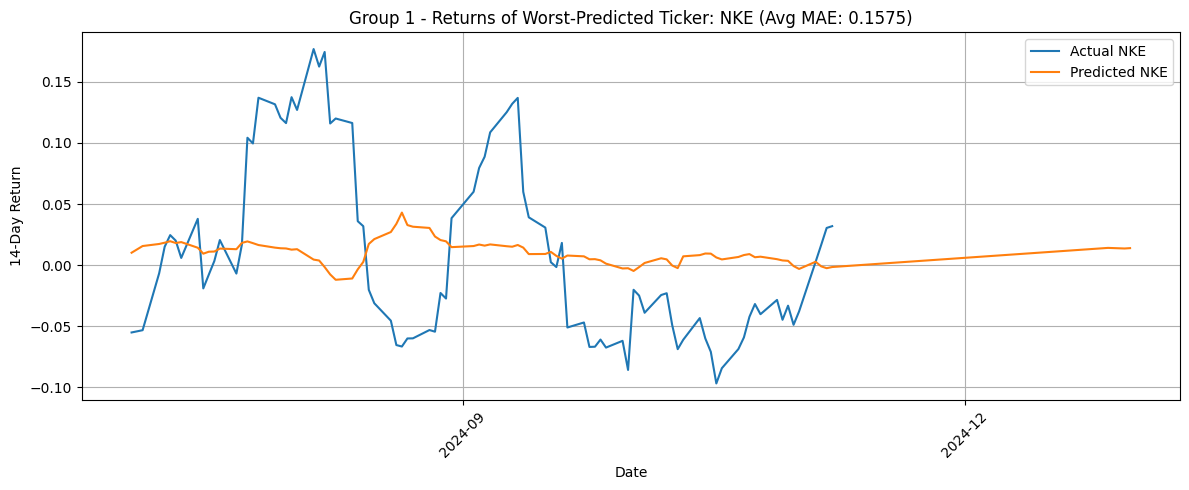

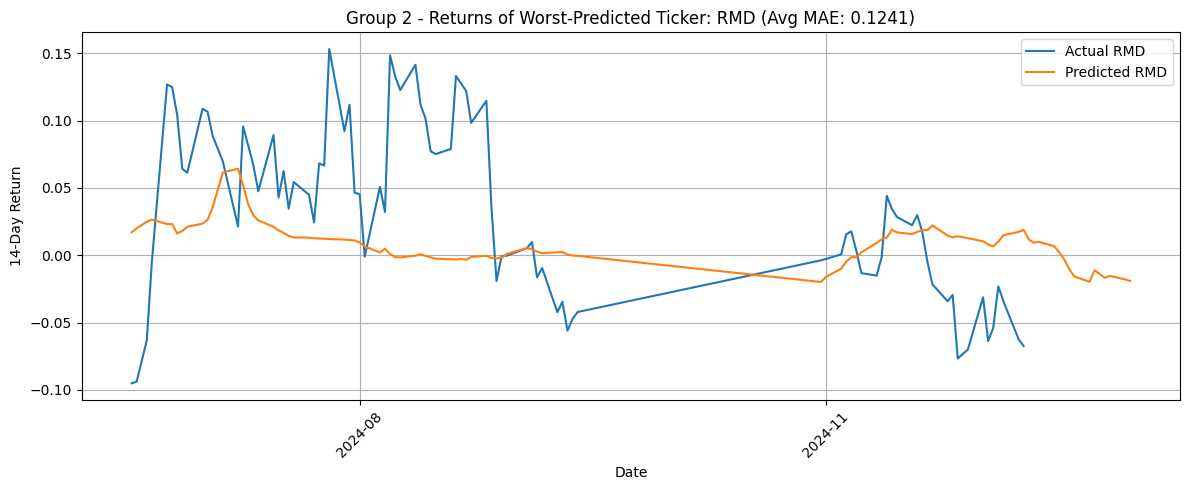

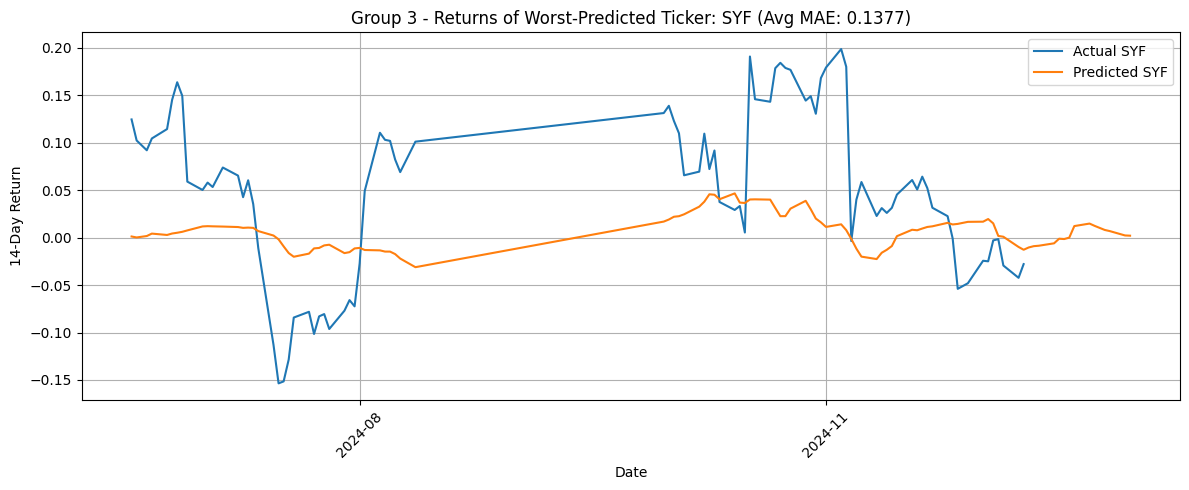

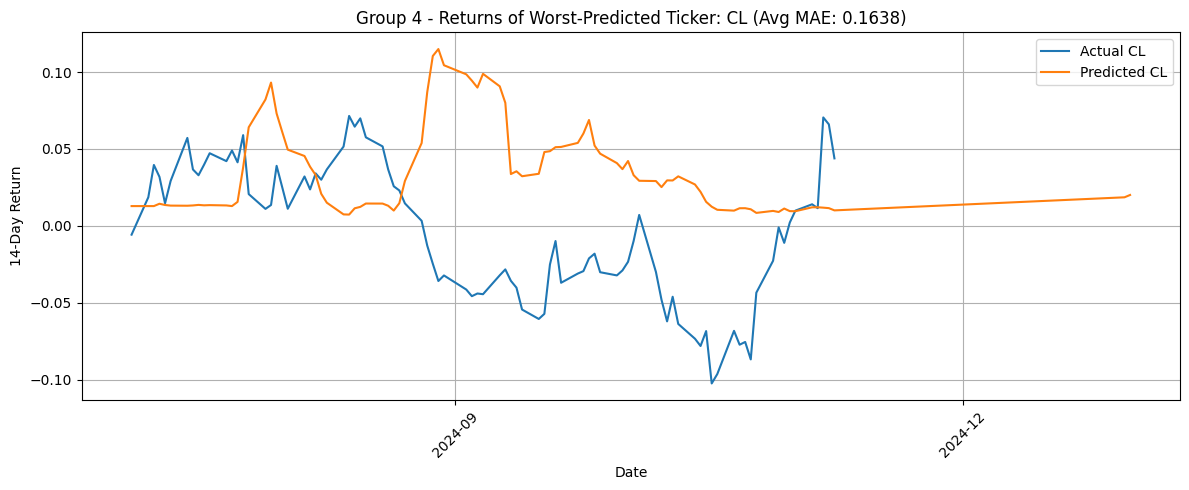

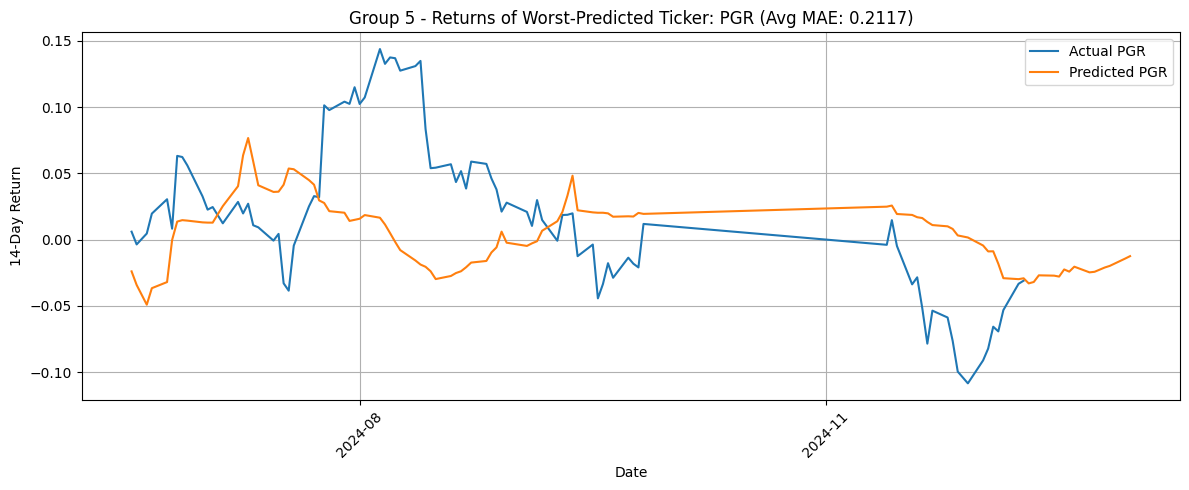

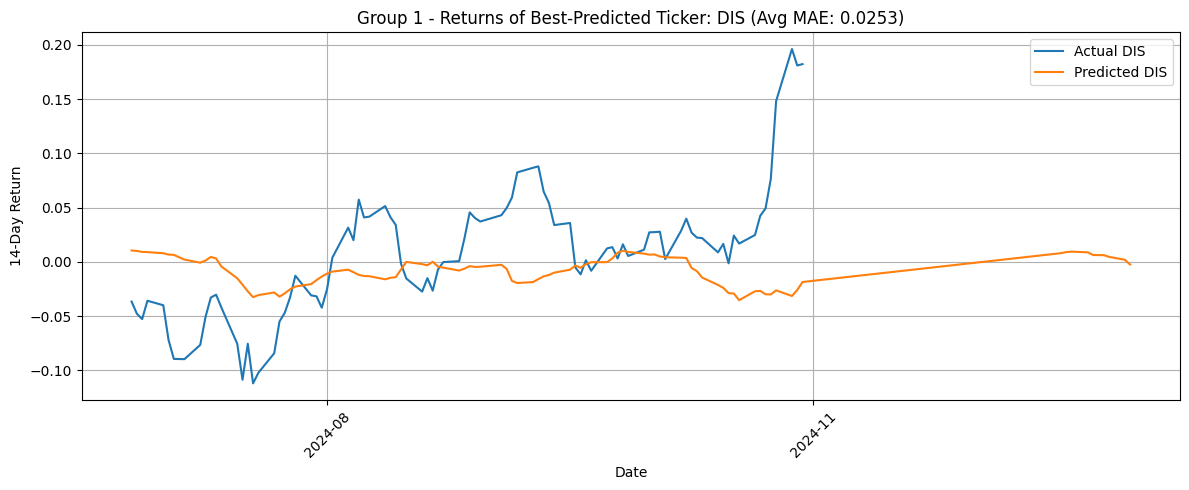

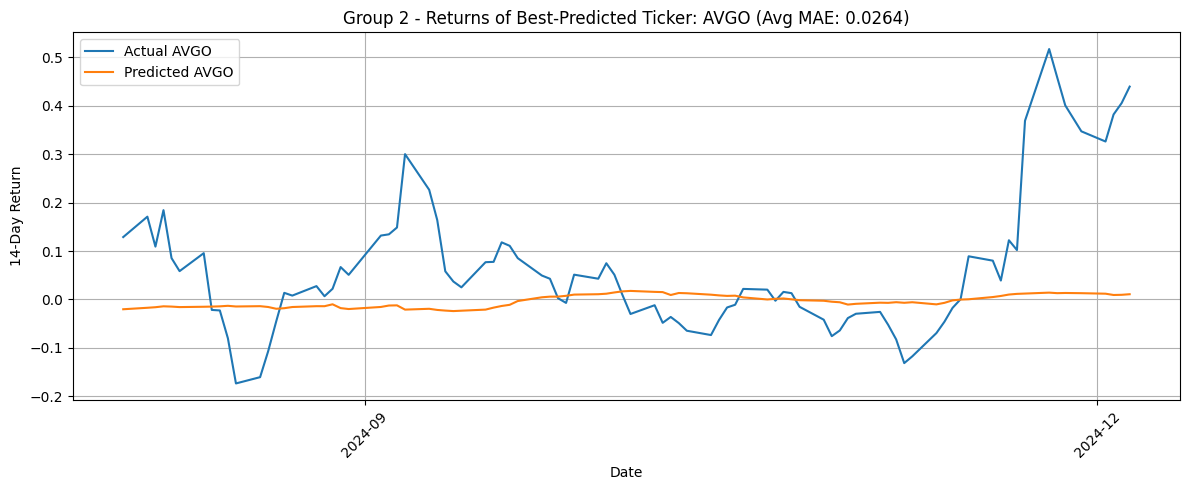

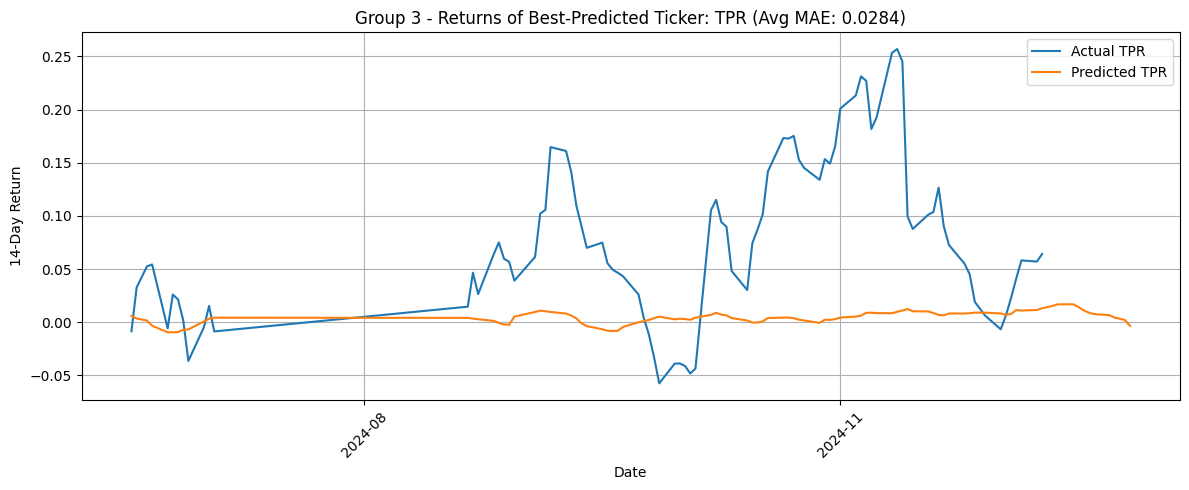

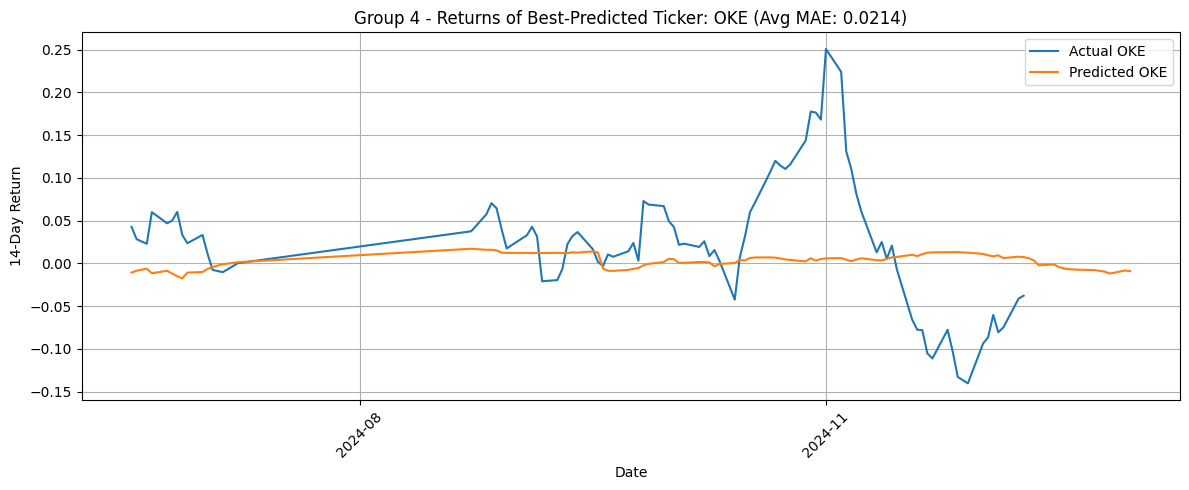

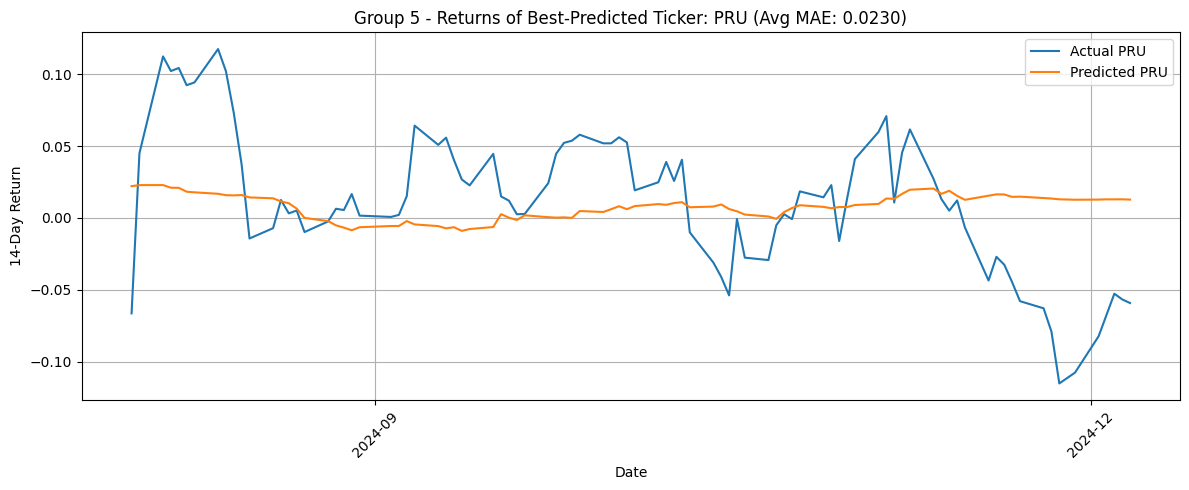

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

assert {'Ticker', 'Close', 'y_true', 'y_pred', 'Date', 'return_14d', 'AbsError'}.issubset(eval_df.columns), "Missing required columns."

avg_price_df = eval_df.groupby('Ticker')['Close'].mean().reset_index()
avg_price_df.rename(columns={'Close': 'AvgPrice'}, inplace=True)

num_groups = 5
if len(avg_price_df) < num_groups:
    print(f"Warning: Not enough tickers ({len(avg_price_df)}) to create {num_groups} price groups. Creating fewer groups.")
    num_groups = max(1, len(avg_price_df) // 20)

if num_groups > 1 and len(np.unique(avg_price_df['AvgPrice'])) >= num_groups:
    avg_price_df = avg_price_df.sort_values('AvgPrice').reset_index(drop=True)
    avg_price_df['Group'] = pd.qcut(avg_price_df.index, q=num_groups, labels=False) + 1
else:
    print("Warning: Not enough unique average prices to create distinct quantiles. Assigning all to group 1.")
    avg_price_df['Group'] = 1

eval_df = eval_df.drop(columns=['AvgPrice', 'Group'], errors='ignore')
eval_df = eval_df.merge(avg_price_df[['Ticker', 'AvgPrice', 'Group']], on='Ticker', how='left')

if eval_df['Group'].isnull().any():
    print("Warning: Some rows in eval_df did not get a group assignment after merge.")

mae_per_ticker = eval_df.groupby(['Group', 'Ticker']).agg(
    AvgAbsError=('AbsError', 'mean'),
    AvgPrice=('AvgPrice', 'mean'),
    TrueMean=('y_true', 'mean'),
    PredMean=('y_pred', 'mean')
).reset_index()

mae_per_ticker = mae_per_ticker.dropna(subset=['AvgAbsError'])

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    if excess_returns.std() == 0:
        return np.nan
    return excess_returns.mean() / excess_returns.std()

risk_metrics_df = eval_df.groupby('Ticker').apply(
    lambda x: pd.Series({
        'Sharpe': sharpe_ratio(x['return_14d']),
    })
).reset_index()

mae_per_ticker = mae_per_ticker.merge(risk_metrics_df, on='Ticker', how='left')

top_10_per_group = {}
num_top_worst = 10

for group_num in sorted(mae_per_ticker['Group'].unique()):
    print(f"\n--- Group {group_num} - Worst Predictions ---")
    group_mae_df = mae_per_ticker[mae_per_ticker['Group'] == group_num]

    top_n_worst = group_mae_df.sort_values('AvgAbsError', ascending=False).head(num_top_worst)
    top_10_per_group[group_num] = top_n_worst

    print(top_n_worst[['Ticker', 'AvgPrice', 'TrueMean', 'PredMean', 'AvgAbsError', 'Sharpe']])

top_5_best_per_group = {}
num_top_best = 5

for group_num in sorted(mae_per_ticker['Group'].unique()):
    print(f"\n--- Group {group_num} - Best Predictions ---")
    group_mae_df = mae_per_ticker[mae_per_ticker['Group'] == group_num]

    top_n_best = group_mae_df.sort_values('AvgAbsError', ascending=True).head(num_top_best)
    top_5_best_per_group[group_num] = top_n_best

    print(top_n_best[['Ticker', 'AvgPrice', 'TrueMean', 'PredMean', 'AvgAbsError', 'Sharpe']])

for group_num in sorted(top_10_per_group.keys()):
    if not top_10_per_group[group_num].empty:
        worst_ticker_symbol = top_10_per_group[group_num].iloc[0]['Ticker']

        group_df = eval_df[eval_df['Ticker'] == worst_ticker_symbol].copy()
        group_df['Date'] = pd.to_datetime(group_df['Date'])
        group_df = group_df.sort_values('Date')

        if not group_df.empty:
            plt.figure(figsize=(12, 5))
            sns.lineplot(data=group_df, x='Date', y='return_14d', label=f'Actual {worst_ticker_symbol}')
            sns.lineplot(data=group_df, x='Date', y='y_pred', label=f'Predicted {worst_ticker_symbol}')

            avg_mae_this_ticker = top_10_per_group[group_num].iloc[0]['AvgAbsError']

            ax = plt.gca()
            ax.set_title(f'Group {group_num} - Returns of Worst-Predicted Ticker: {worst_ticker_symbol} (Avg MAE: {avg_mae_this_ticker:.4f})')
            ax.set_ylabel("14-Day Return")
            ax.set_xlabel("Date")
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.show()
        else:
            print(f"No data found for ticker {worst_ticker_symbol} (Group {group_num}) to plot.")
    else:
        print(f"No worst tickers found for Group {group_num}.")

for group_num in sorted(top_5_best_per_group.keys()):
    if not top_5_best_per_group[group_num].empty:
        best_ticker_symbol = top_5_best_per_group[group_num].iloc[0]['Ticker']

        group_df = eval_df[eval_df['Ticker'] == best_ticker_symbol].copy()
        group_df['Date'] = pd.to_datetime(group_df['Date'])
        group_df = group_df.sort_values('Date')

        if not group_df.empty:
            plt.figure(figsize=(12, 5))
            sns.lineplot(data=group_df, x='Date', y='return_14d', label=f'Actual {best_ticker_symbol}')
            sns.lineplot(data=group_df, x='Date', y='y_pred', label=f'Predicted {best_ticker_symbol}')

            avg_mae_this_ticker = top_5_best_per_group[group_num].iloc[0]['AvgAbsError']

            ax = plt.gca()
            ax.set_title(f'Group {group_num} - Returns of Best-Predicted Ticker: {best_ticker_symbol} (Avg MAE: {avg_mae_this_ticker:.4f})')
            ax.set_ylabel("14-Day Return")
            ax.set_xlabel("Date")
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.show()
        else:
            print(f"No data found for ticker {best_ticker_symbol} (Group {group_num}) to plot.")
    else:
        print(f"No best tickers found for Group {group_num}.")


